In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from snowballstemmer import NepaliStemmer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('dataset/output/merged_data.csv')
df.sample(5)

,class,text
3404,Politics & Society,"﻿बृजमान तामाङ/बिरेन्द्र बजार, २४ चैत । नेपाल त..."
3208,Politics & Society,"﻿बीरगञ्ज, २९ माघ । राष्ट्रिय मधेश समाजवादी पार..."
4348,Leisure,﻿प्रमुख प्रतिपक्षी नेकपा एमालेले प्याकेज सहमति...
2256,Politics & Society,﻿बहुचर्चित धोबीघाट भेलापछि माओवादी आन्दोलनमा व...
604,Economics,कुल बजार पुँजीकरणमा १५.२० अर्ब रुपैयाँ वृद्धि\...


In [3]:
# Function to load stopwords from a file
def load_stopwords(file_path):
    with open(file_path, encoding='utf-8') as fp:
        return list(map(lambda x: x.strip(), fp.readlines()))


# Function to load punctuation words from a file
def load_punctuation(file_path):
    with open(file_path, encoding='utf-8') as fp:
        return list(map(lambda x: x.strip(), fp.readlines()))





In [4]:
from tqdm import tqdm

# Update the preprocess_text function to include tqdm
def preprocess_text(data, stop_words, punctuation_words, stemmer, noise_chars):
    clean_text = []
    # Wrap the loop with tqdm to track the progress
    for row in tqdm(data, desc="Preprocessing text data", unit="text"):
        words = row.strip().split(" ")
        nwords = []
        for word in words:
            if word not in punctuation_words and word not in stop_words:
                word = stemmer.stemWord(word)
                if not any(noise in word for noise in noise_chars) and len(word) > 1:
                    word = word.replace("(", "").replace(")", "")
                    nwords.append(word)
        clean_text.append(" ".join(nwords))
    return clean_text




In [5]:
# Create a pipeline to handle vectorization, TF-IDF transformation, and classification
def create_model(ngram_range=(1, 2), alpha=1.0):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    tfidf_transformer = TfidfTransformer()
    model = MultinomialNB(alpha=alpha)

    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('tfidf', tfidf_transformer),
        ('classifier', model)
    ])

    return pipeline

In [6]:
classes = {c: i for i, c in enumerate(df['class'].unique())}
classes

{'Technology & Innovation': 0,
 'Economics': 1,
 'Culture & Literature': 2,
 'Education': 3,
 'Leisure': 4,
 'Health': 5,
 'Politics & Society': 6,
 'World & Migration': 7}

In [7]:
# Model fitting and evaluation
def train_and_evaluate(X_train, Y_train, X_test, Y_test, ngram_range=(1, 2), alpha=1.0):
    # Create the model pipeline
    pipeline = create_model(ngram_range, alpha)

    # Train the model
    pipeline.fit(X_train, Y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Print classification report
    print(classification_report(Y_test, y_pred))

    # Confusion matrix visualization
    cm = confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Return the trained pipeline for saving
    return pipeline


In [8]:
# Save model and vectorizer to files
def save_model(model, model_filename, vectorizer_filename):
    pickle.dump(model, open(model_filename, 'wb'))
    pickle.dump(model.named_steps['vectorizer'], open(vectorizer_filename, 'wb'))

In [9]:
# Load stopwords and punctuation words
stop_words = load_stopwords("nepali_stopwords.txt")
punctuation_words = load_punctuation("nepali_punctuation.txt")

# Create a stemmer
stemmer = NepaliStemmer()

# Define noise characters (numbers)
noise_chars = "1,2,3,4,5,6,7,8,9,0,०,१,२,३,४,५,६,७,८,९".split(",")

In [11]:
# Preprocess text data with progress bar
data = pd.DataFrame()
data["text"] = preprocess_text(df["text"], stop_words, punctuation_words, stemmer, noise_chars)
data["label"] = df["class"]

Preprocessing text data:   7%|▋         | 361/4890 [00:01<00:15, 296.47text/s]

Preprocessing text data: 100%|██████████| 4890/4890 [00:21<00:00, 223.42text/s]


In [12]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42)

c:\Users\Suyash Shrestha\AppData\Local\pypoetry\Cache\virtualenvs\news-title-classifier-Q5gfBSGz-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Suyash Shrestha\AppData\Local\pypoetry\Cache\virtualenvs\news-title-classifier-Q5gfBSGz-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Suyash Shrestha\AppData\Local\pypoetry\Cache\virtualenvs\news-title-classifier-Q5gfBSGz-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is il

                         precision    recall  f1-score   support

   Culture & Literature       0.00      0.00      0.00        69
              Economics       0.75      0.51      0.61       251
              Education       0.00      0.00      0.00        23
                 Health       0.00      0.00      0.00         8
                Leisure       1.00      0.09      0.16       184
     Politics & Society       0.34      0.97      0.51       280
Technology & Innovation       0.00      0.00      0.00        89
      World & Migration       0.00      0.00      0.00        74

               accuracy                           0.42       978
              macro avg       0.26      0.20      0.16       978
           weighted avg       0.48      0.42      0.33       978



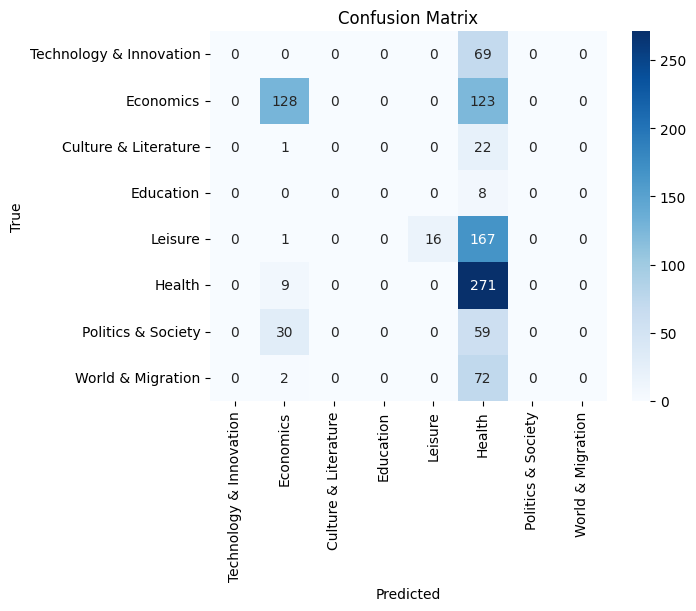

In [13]:
# Train and evaluate the model
model = train_and_evaluate(X_train, Y_train, X_test, Y_test)

In [14]:
# Save the trained model and vectorizer
save_model(model, 'news_pred_model_v1.pickle', 'news_pred_vectorizer_v1.pickle')

In [15]:
# Example of predicting new text
new_text = """
काठमाडौँ — नेपाली यू–१९ महिला क्रिकेट टोलीले आईसीसी यू–१९ महिला ट्वान्टी–२० विश्वकपको एसिया छनोटमा तेस्रो जित हात पारेको छ । नेपालले यूएईमा भइरहेको प्रतियोगितामा आइतबार थाइल्यान्डलाई १ सय ६ रनले पराजित गर्‍यो ।
"""

prediction = model.predict([new_text])
print("Predicted category:", prediction)

Predicted category: ['Politics & Society']
